In [2]:
import collections
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train_images = mnist.train.images
test_images = mnist.test.images

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist.train.labels.shape

(55000, 10)

In [3]:
def display_weights(weights, num_hidden, num_images):
    perm = np.random.permutation(num_hidden)[:num_images]
    plt.figure()
    for idx, p in enumerate(perm):
        plt.subplot(2, 5, idx + 1)
        plt.axis('off')
        picture = np.array([i[p] for i in weights])
        plt.imshow(picture.reshape(28,28), cmap='gray')

In [1]:
class Rbm:
    """
    My little restricted boltzmann machine class.
    All optimizations are made using Geoffrey Hintons paper:
    "A Practical Guide to Training Restricted Boltzmann Machines"
    """
    def weight_variable(self, shape, initial=None):
        if not initial:
            initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    def bias_variable(self, shape, initial=None):
        if not initial:
            initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

    def __init__(self, num_hidden=250, visible_unit_type='bin', learning_rate=0.01,
                 std_dev=0.1, num_epochs=10,batch_size=10,
                 gibbs_sampling_steps=1, log_device_placement=False,
                 last_update_prob_hidden=True, weight_decay_rate=0.0001):
        """

        Optimization parameters:
        @param: last_update_prob: Whether the last update use the hidden layer probability as it's state.
                                  it tends to reduce the noise in the training.
        """
        # Model parameters
        self.num_hidden = num_hidden

        if visible_unit_type not in ['gauss', 'bin']:
            raise Error('Invalid node type.')

        self.visible_unit_type = visible_unit_type

        # Statistical model parameters
        self.stddev = std_dev
        self.learning_rate = learning_rate

        # Iteration parameters
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.gibbs_sampling_steps = gibbs_sampling_steps

        # Optimization parameters
        self.last_update_prob_hidden = last_update_prob_hidden
        self.weight_decay_rate = weight_decay_rate

        # Tensorflow config parameters
        config = {
            'log_device_placement': log_device_placement
        }

        self.g = tf.Graph()
        self.tf_session = tf.Session(graph=self.g, config=tf.ConfigProto(**config))

    def fit(self, train_dataset, validation_dataset):

        # Define the number of features. (I.e..: The number of columns in the training data)
        self.num_features = train_dataset.shape[1]

        with self.g.as_default():
            # Create Placeholder values. ------------------------------------------------------------
            self.batch = tf.placeholder(tf.float32, shape=(None, self.num_features))

            # This variable will hold a random distribution in every trainings step,
            # it is used to decide the binary state of the hidden variables in the gibbs
            # sampling step.
            self.h_rand = tf.placeholder(tf.float32, [None, self.num_hidden])

            # Same for the visible variables.
            self.v_rand = tf.placeholder(tf.float32, [None, self.num_features])

            # Initialize the weights and the biases. -------------------------------------------------

            # Initialize the bias of the visible unit i to log(p_i/(1-p_i)) where p_i is the proportion of
            # training vectors in which unit i is on.

            init_visible_bias = []
            for i in range(train_dataset.shape[1]):
                p_i = np.count_nonzero(train_dataset[:, i]) / float(train_dataset.shape[0])
                init_visible_bias.append(np.log(p_i/(1-p_i)))

            self.W = self.weight_variable([self.num_features, self.num_hidden])
            self.h_biases = self.bias_variable([self.num_hidden])
            self.v_biases = self.bias_variable([self.num_features], init_visible_bias)

            # Build the model ------------------------------------------------------------------------
            # Perform the first gibbs sampling step.
            last_update = self.gibbs_sampling_steps == 1
            h_prob0, h_state0, v_prob, h_prob1, h_state1 = self.gibbs_sampling_step(
                self.batch,
                self.num_features,
                last_update)

            # Compute the Positive associations. I.e. the when the visible units are
            # clamped to the input.
            if self.visible_unit_type == 'bin':
                positive = tf.matmul(tf.transpose(v_prob), h_prob0)

            elif self.visible_unit_type == 'gauss':
                positive = tf.matmul(tf.transpose(self.batch), h_prob0)

            # Initiate the free running gibbs sampling part.
            nn_input = v_prob
            for step in range(self.gibbs_sampling_steps - 1):
                last_update = step == (self.gibbs_sampling_steps - 1)
                h_prob0, h_state0, v_prob, hprob1, hstate1 = self.gibbs_sampling_step(
                    nn_input,
                    self.num_features,
                    last_update)
                nn_input = v_prob

            # Compute the negative phase, when we reconstruct the visible nodes form
            # the hidden ones.
            negative = tf.matmul(tf.transpose(v_prob), h_prob1)

            # Define the update parameters.
            w_upd8 = self.W.assign_add(
                self.learning_rate * (positive - negative) / self.batch_size) + self.weight_decay_rate * tf.nn.l2_loss(self.W)

            h_bias_upd8 = self.h_biases.assign_add(self.learning_rate *
                                                   tf.reduce_mean(h_prob0 - h_prob1, 0))

            v_bias_upd8 = self.v_biases.assign_add(self.learning_rate *
                                                   tf.reduce_mean(self.batch - v_prob, 0))

            updates = [w_upd8, v_bias_upd8, h_bias_upd8]

            # Create a mean square cost function node.
            softmax = tf.nn.softmax(v_prob)
            cost = tf.sqrt(tf.reduce_mean(tf.square(self.batch - v_prob)))
            
            # Train the model. -----------------------------------------------------------------------
            sess = self.tf_session

            sess.run(tf.initialize_all_variables())

            print("Train set dimensions: (%s, %s)" % train_dataset.shape)
            for i in range(self.num_epochs):
                print("epoch: %s" % i)
                np.random.shuffle(train_dataset)
                batches = np.array_split(train_dataset, train_dataset.shape[0] // self.batch_size)

                for j, batch in enumerate(batches):
                    #                     if j % 100 == 0:
                    #                         print("batch_number: %s" % j)
                    sess.run(
                        updates,
                        feed_dict = {
                            self.batch: batch,
                            self.h_rand: np.random.rand(batch.shape[0],
                                                        self.num_hidden),
                            self.v_rand: np.random.rand(batch.shape[0],
                                                        batch.shape[1])
                        }
                    )
                rec_loss = sess.run(
                    cost,
                    feed_dict={
                        self.batch: validation_dataset,
                        self.h_rand: np.random.rand(validation_dataset.shape[0],
                                                    self.num_hidden),
                        self.v_rand: np.random.rand(validation_dataset.shape[0],
                                                    validation_dataset.shape[1])
                    })
                print('Reconstruction loss at epoch %s: %s' % (i, rec_loss))

    def dream(self, step_number=10):
        nn_input = self.v_rand
        
        for step in range(step_number):
            last_update = step == (step_number - 1)
            h_prob0, h_state0, v_prob, hprob1, hstate1 = self.gibbs_sampling_step(
                nn_input,
                self.num_features,
                last_update)
            nn_input = v_prob
            
        sess = self.tf_session
        result = sess.run(nn_input,
                          feed_dict={
                              self.v_rand: [np.random.rand(self.num_features)]
                          })
        return result
    
    def fit_predictor(self, train_data, train_labels, validate_data, validate_labels, test_data, test_labels):
        num_classes = train_labels.shape[1]
        
        with self.g.with_as_default():
            self.W_prediction = weight_variable([self.num_hidden, num_classes])
            self.biases_prediction = bias_variable([num_classes])
            
            # Create a softmax for class prediction.
            h_prob_predict = tf.nn.sigmoid(tf.matmul(self.batch, self.W) + self.h_biases)
            h_state_predict = tf.nn.relu(tf.sign(h_prob_predict - self.h_rand))
            
            logits = tf.nn.matmul(h_state_predict, self.W_prediction) + self.biases_prediction
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, batch_labels))
            optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
        
        num_steps = 3001

        with tf.Session(graph=graph) as session:
            
    
            # These two lines are measure the accuracy of our model.
            # y_conv is a softmax output, the highest entry is the most probable according to our model 
            # (e.g.: [0.7, 0.2, 0.5, 0.5])
            # tf_train_labels are the original labels for the training set. 
            # (eg.: [0, 0, 0, 1])
            correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(tf_train_labels,1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            tf.initialize_variables([self.W_prediction, self.biases_prediction])
            print("Initialized")
            for step in range(num_steps):
                index = int(np.random.uniform(0.0, self.train_labels.shape[0] - batch_size))
                # Pick an offset within the training data, which has been randomized.
                # Note: we could use better randomization across epochs.
                offset = (index * batch_size) % (train_labels.shape[0] - batch_size)

                # Generate a minibatch.
                batch_data = train_dataset[offset:(offset + batch_size), :]
                batch_labels = train_labels[offset:(offset + batch_size), :]

                # Prepare a dictionary telling the session where to feed the minibatch.
                # The key of the dictionary is the placeholder node of the graph to be fed,
                # and the value is the numpy array to feed to it.
                feed_dict = {tf_train_dataset : batch_data, 
                             tf_train_labels : batch_labels}


                if step % 100 == 0:
                    train_accuracy = accuracy.eval(feed_dict={tf_train_batch:  batch_data, 
                                                              tf_train_labels: batch_labels, 
                                                              keep_prob: 1.0})
                    print("step %d, training accuracy %g" % (step, train_accuracy))
                    
                optimizer.run(feed_dict={tf_train_batch: batch_data, 
                                      tf_train_labels: batch_labels, 
                                      keep_prob: 0.5})

            print("test accuracy %g" % accuracy.eval(feed_dict={tf_train_batch: test_data,
                                                                tf_train_labels: test_labels, 
                                                                keep_prob: 1.0}))
    
    def gibbs_sampling_step(self, visible, num_features, last_update=False):
        # Sample hidden from visible.
        h_prob0 = tf.nn.sigmoid(tf.matmul(visible, self.W) + self.h_biases)
        h_state0 = tf.nn.relu(tf.sign(h_prob0 - self.h_rand))

        # Sample visible from hidden
        visible_activation = tf.matmul(h_prob0, tf.transpose(self.W)) + self.v_biases

        if self.visible_unit_type == 'bin':
            v_probs = tf.nn.sigmoid(visible_activation)

        elif self.visible_unit_type == 'gauss':
            v_probs = tf.truncated_normal((1, num_features), mean=visible_activation, stddev=self.stddev)

        # Sample hidden from visible.
        h_prob1 = tf.nn.sigmoid(tf.matmul(v_probs, self.W) + self.h_biases)

        if last_update and self.last_update_prob_hidden:
            h_state1 = h_prob1
        else:
            h_state1 = tf.nn.relu(tf.sign(h_prob1 - self.h_rand))

        return (h_prob0, h_state0, v_probs, h_prob1, h_state1)

    def get_model_parameters(self):
        return {
            'W': self.tf_session.run(self.W),
            'h_biases': self.tf_session.run(self.h_biases),
            'v_biases': self.tf_session.run(self.v_biases)
        }

    def __del__(self):
        self.tf_session.close()

In [25]:
try:
    del rbm
except:
    pass

rbm = Rbm(num_hidden=500, num_epochs=10)

In [54]:
single_number_train_data_all = np.array([mnist.train.images[idx] for idx, one in enumerate(mnist.train.labels) if one[2] == 1])

split_point = int(single_number_train.shape[0] * 0.9)
single_number_train_data = single_number_train_data_all[:split_point]
single_number_validate_data = single_number_train_data_all[split_point:]

single_number_train_labels_all = np.array([mnist.train.labels[idx] for idx, one in enumerate(mnist.train.labels) if one[2] == 1])
single_number_train_labels = single_number_train_labels_all[:split_point]
single_number_validate_labels = single_number_train_labels_all[split_point:]

single_number_test = np.array([mnist.test.images[idx] for idx, one in enumerate(mnist.test.labels) if one[2] == 1])

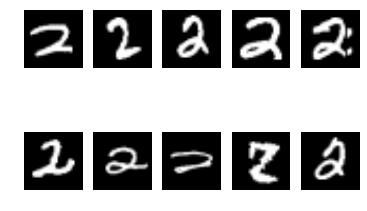

In [55]:
perm = np.random.permutation(single_number_train_data.shape[0])[:10]
plt.figure()
for idx, p in enumerate(perm):
    plt.subplot(2, 5, idx + 1)
    plt.axis('off')
    plt.imshow(single_number_train_data[p].reshape(28,28), cmap='gray')

In [56]:
print(single_number_train_data.shape)
print(single_number_train_labels.shape)
print(single_number_validate_data.shape)
print(single_number_validate_labels.shape)

(3588, 784)
(3588, 10)
(1882, 784)
(1882, 10)


In [57]:
rbm.fit(single_number_train_data, single_number_validate_data)

Train set dimensions: (3588, 784)
epoch: 0
Reconstruction loss at epoch 0: 0.20457
epoch: 1
Reconstruction loss at epoch 1: 0.19433
epoch: 2
Reconstruction loss at epoch 2: 0.186497
epoch: 3
Reconstruction loss at epoch 3: 0.180489
epoch: 4
Reconstruction loss at epoch 4: 0.175494
epoch: 5
Reconstruction loss at epoch 5: 0.171336
epoch: 6
Reconstruction loss at epoch 6: 0.167811
epoch: 7
Reconstruction loss at epoch 7: 0.164644
epoch: 8
Reconstruction loss at epoch 8: 0.161732
epoch: 9
Reconstruction loss at epoch 9: 0.15919


10 epoch testing best reconstruction losses:
- At the last update use the hidden layer probability as it's state: 0.193323
- Proper visible bias initialization: 0.193112
- L2 loss applied with a rate of 0.0001: 0.192699

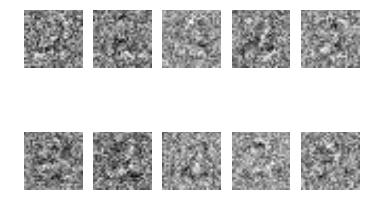

In [30]:
weights = rbm.get_model_parameters()['W']
perm = np.random.permutation(250)[:10]
plt.figure()
for idx, p in enumerate(perm):
    plt.subplot(2, 5, idx + 1)
    plt.axis('off')
    picture = np.array([i[p] for i in weights])
    plt.imshow(picture.reshape(28,28), cmap='gray')

Dream after 1 epoch

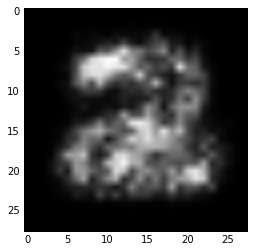

In [33]:
plt.figure()
plt.imshow(rbm.dream(2).reshape(28,28), cmap='gray')

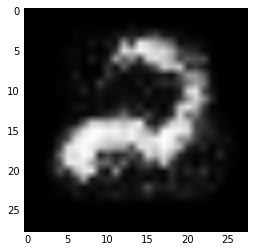

In [38]:
plt.figure()
plt.imshow(rbm.dream(100).reshape(28,28), cmap='gray')

In [1]:
rbm.fit_predictor(single_number_train_data, single_number_train_labels)

NameError: name 'rbm' is not defined

SyntaxError: invalid syntax (<ipython-input-3-54e939c2baf3>, line 2)